In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import matplotlib.pyplot as plt

import jaxlayerlumos as jll
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_units as jll_utils_units

In [2]:
str_mode = "reflection"
materials = ["Air", "TiO2", "Ag", "TiO2", "FusedSilica"]
num_layers = len(materials) - 2

seed = 42
num_iter = 100

In [3]:
frequencies = jll_utils_spectra.get_frequencies_visible_light()
wavelengths = jll_utils_spectra.convert_frequencies_to_wavelengths(frequencies)
wavelengths_in_nm = wavelengths / jll_utils_units.get_nano()

n_k = jll_utils_materials.get_n_k(materials, frequencies)

print(f"frequencies.shape {frequencies.shape}")
print(f"wavelengths.shape {wavelengths.shape}")
print(f"wavelengths_in_nm.shape {wavelengths_in_nm.shape}")
print(f"n_k.shape {n_k.shape}")

frequencies.shape (1001,)
wavelengths.shape (1001,)
wavelengths_in_nm.shape (1001,)
n_k.shape (1001, 5)


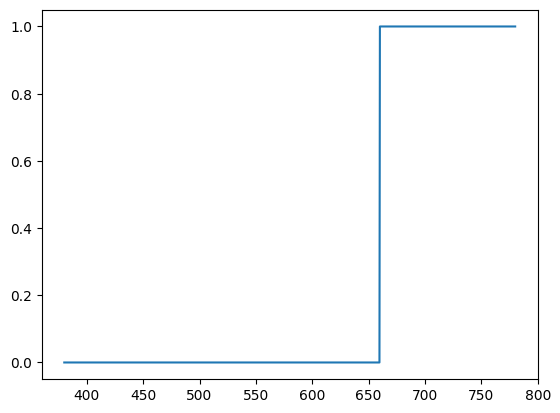

In [4]:
target_spectrum = jnp.zeros_like(frequencies)
target_spectrum = target_spectrum.at[700:].set(1.0)

plt.plot(wavelengths_in_nm, target_spectrum)

In [5]:
def transform(inputs):
    thicknesses = jnp.clip(inputs, min=0)
    thicknesses = jnp.concatenate([
        jnp.array([0]),
        thicknesses,
        jnp.array([0])
    ], axis=0)
    thicknesses *= jll_utils_units.get_nano()

    return thicknesses

def get_spectrum(inputs):
    angles = jnp.array([0.0])
    thicknesses = transform(inputs)

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, thetas=angles)

    R_TE = R_TE[0]
    T_TE = T_TE[0]
    R_TM = R_TM[0]
    T_TM = T_TM[0]

    if str_mode == "transmission":
        spectrum = (T_TE + T_TM) / 2
    elif str_mode == "reflection":
        spectrum = (R_TE + R_TM) / 2
    else:
        raise ValueError

    return spectrum

def objective(inputs, target_spectrum):
    spectrum = get_spectrum(inputs)
    loss = jnp.sum(jnp.abs(spectrum - target_spectrum)**2)

    return loss

In [6]:
params = jax.random.uniform(jax.random.key(seed), shape=(num_layers, ), minval=0, maxval=100)

optimizer = optax.contrib.dog()
optimizer_state = optimizer.init(params)

fun_objective = lambda inputs: objective(inputs, target_spectrum)

parameters = []
loss_values = []

for ind in range(0, num_iter):
    values, grads = jax.value_and_grad(fun_objective)(params)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params, value=values)
    params = optax.apply_updates(params, updates)

    loss_value = fun_objective(params)

    parameters.append(onp.array(params))
    loss_values.append(loss_value)

    print(f"Iteration {ind + 1}: {loss_value:.8f}", flush=True)

Iteration 1: 615.51289818
Iteration 2: 615.51274003
Iteration 3: 615.51251959
Iteration 4: 615.51221845
Iteration 5: 615.51181440
Iteration 6: 615.51128054
Iteration 7: 615.51058442
Iteration 8: 615.50968698
Iteration 9: 615.50854146
Iteration 10: 615.50709205
Iteration 11: 615.50527240
Iteration 12: 615.50300384
Iteration 13: 615.50019340
Iteration 14: 615.49673147
Iteration 15: 615.49248912
Iteration 16: 615.48731495
Iteration 17: 615.48103152
Iteration 18: 615.47343108
Iteration 19: 615.46427063
Iteration 20: 615.45326613
Iteration 21: 615.44008557
Iteration 22: 615.42434083
Iteration 23: 615.40557783
Iteration 24: 615.38326471
Iteration 25: 615.35677741
Iteration 26: 615.32538205
Iteration 27: 615.28821308
Iteration 28: 615.24424597
Iteration 29: 615.19226291
Iteration 30: 615.13080898
Iteration 31: 615.05813598
Iteration 32: 614.97212927
Iteration 33: 614.87021180
Iteration 34: 614.74921655
Iteration 35: 614.60521515
Iteration 36: 614.43328466
Iteration 37: 614.22718652
Iteration 

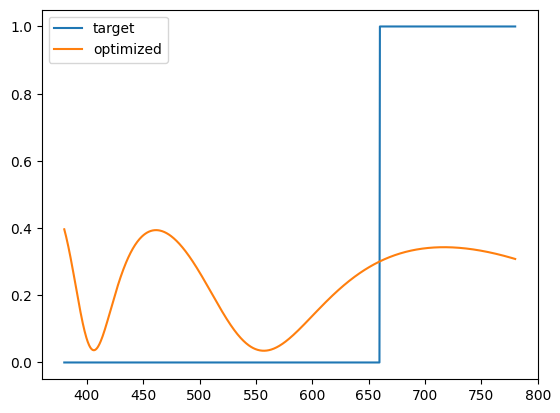

In [7]:
spectrum_optimized = get_spectrum(params)

plt.plot(wavelengths_in_nm, target_spectrum, label='target')
plt.plot(wavelengths_in_nm, spectrum_optimized, label='optimized')

plt.legend()